In [1]:
# Cell 1: imports, reproducibility, GPU check
import os, random, warnings
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# reproducibility
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


TensorFlow version: 2.19.0
GPU available: []


In [2]:
# Cell 2: Mount Drive (run this in Colab)
from google.colab import drive
drive.mount('/content/drive')

# Update these two variables to match your Drive structure
DATASET_ROOT = '/content/drive/MyDrive/'
SUBDIR = 'Dataset'   # folder that contains class subfolders (one folder per class)
ROOT_DIR = os.path.join(DATASET_ROOT, SUBDIR)
print("ROOT_DIR:", ROOT_DIR)
assert os.path.isdir(ROOT_DIR), f"Dataset folder not found: {ROOT_DIR}"

# list classes and counts
class_dirs = sorted(glob(os.path.join(ROOT_DIR, '*')))
print("Classes found:", [os.path.basename(p) for p in class_dirs])
for p in class_dirs:
    cnt = len([f for f in os.listdir(p) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    print(f"  {os.path.basename(p)}: {cnt} images")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ROOT_DIR: /content/drive/MyDrive/Dataset
Classes found: ['Black Sopt', 'Dry Leaf', 'Healthy Leaf', 'Leaf Holes']
  Black Sopt: 417 images
  Dry Leaf: 471 images
  Healthy Leaf: 555 images
  Leaf Holes: 412 images


In [3]:
# Cell 3: model constructors, preprocessors and helpers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# model constructors + preprocessing functions
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input as preprocess_efficientnet
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as preprocess_densenet
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as preprocess_vgg

# sklearn metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model mapping: key -> (constructor, preprocess_fn, input_size)
MODEL_MAP = {
    'densenet': (DenseNet121, preprocess_densenet, (224,224)),
    'resnet': (ResNet50, preprocess_resnet, (224,224)),
    'vgg': (VGG16, preprocess_vgg, (224,224)),
    'efficientnetb0': (EfficientNetB0, preprocess_efficientnet, (224,224)),  # <-- NEW
}


# DEFAULT training config (you can change these later)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
EPOCHS_FROZEN = 6
EPOCHS_FINE = 10
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINE = 1e-5
DROPOUT_RATE = 0.5
DENSE_UNITS = 256
SAVE_DIR = '/content'  # change to '/content/drive/MyDrive/...' to save directly to Drive

# helper: generators
def get_generators(root_dir, img_size, preprocess_fn, batch_size=BATCH_SIZE, val_split=VAL_SPLIT, seed=SEED):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.15,
        horizontal_flip=True,
        validation_split=val_split
    )
    train_gen = train_datagen.flow_from_directory(
        root_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', subset='training', shuffle=True, seed=seed
    )
    val_gen = train_datagen.flow_from_directory(
        root_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', subset='validation', shuffle=False, seed=seed
    )
    return train_gen, val_gen

# helper: build model
def build_model(base_constructor, input_shape, num_classes, dropout_rate=DROPOUT_RATE, dense_units=DENSE_UNITS, base_trainable=False):
    base = base_constructor(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = base_trainable
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(max(0.3, dropout_rate-0.1))(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=outputs, name=f"{base_constructor.__name__}_custom")
    return model, base


In [4]:
# Cell 4: train_and_evaluate for one model (run this cell)
def train_and_evaluate(model_key, root_dir=ROOT_DIR, save_dir=SAVE_DIR):
    constructor, preprocess_fn, img_size = MODEL_MAP[model_key]
    print("\n" + "="*40)
    print("MODEL:", model_key, "input_size:", img_size)
    print("="*40)

    train_gen, val_gen = get_generators(root_dir, img_size, preprocess_fn)
    num_classes = train_gen.num_classes
    idx_to_class = {v:k for k,v in train_gen.class_indices.items()}
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
    print("Class names (index order):", class_names)

    model, base = build_model(constructor, input_shape=(img_size[0], img_size[1], 3), num_classes=num_classes, base_trainable=False)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_HEAD), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    ckpt_path = os.path.join(save_dir, f"best_{model_key}.keras")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    # Train head
    hist_head = model.fit(train_gen, epochs=EPOCHS_FROZEN, validation_data=val_gen, callbacks=callbacks, verbose=1)

    # Fine-tune: unfreeze and continue
    print("Unfreezing base model for fine-tuning...")
    for layer in base.layers:
        layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_FINE), loss='categorical_crossentropy', metrics=['accuracy'])
    hist_fine = model.fit(train_gen, epochs=EPOCHS_FINE, validation_data=val_gen, callbacks=callbacks, verbose=1)

    # load best weights if saved
    if os.path.exists(ckpt_path):
        model.load_weights(ckpt_path)
        print("Loaded best weights from:", ckpt_path)

    # Evaluate
    val_gen.reset()
    val_loss, val_acc = model.evaluate(val_gen, verbose=1)
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc*100:.2f}%")

    # detailed metrics
    y_prob = model.predict(val_gen, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = val_gen.classes
    sk_acc = accuracy_score(y_true, y_pred)
    print(f"Sklearn accuracy_score: {sk_acc*100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # confusion matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6 + 0.5*len(class_names), 5 + 0.5*len(class_names)))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='plasma')
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(f'Confusion Matrix - {model_key}')
    plt.show()

    final_path = os.path.join(save_dir, f"final_{model_key}.keras")
    model.save(final_path)
    print("Saved final model to:", final_path)

    return {
        'model_key': model_key, 'val_loss': float(val_loss), 'val_acc': float(val_acc),
        'sklearn_acc': float(sk_acc), 'final_path': final_path, 'ckpt_path': ckpt_path
    }



MODEL: densenet input_size: (224, 224)
Found 1485 images belonging to 4 classes.
Found 370 images belonging to 4 classes.
Class names (index order): ['Black Sopt', 'Dry Leaf', 'Healthy Leaf', 'Leaf Holes']
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "DenseNet121_custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/6
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5161 - loss: 1.2750 
Epoch 1: val_accuracy improved from -inf to 0.91892, saving model to /content/best_densenet.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 1201s 25s/step - accuracy: 0.5185 - loss: 1.2686 - val_accuracy: 0.9189 - val_loss: 0.2781 - learning_rate: 0.0010
Epoch 2/6
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7689 - loss: 0.5749
Epoch 2: val_accuracy improved from 0.91892 to 0.92432, saving model to /content/best_densenet.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 619s 12s/step - accuracy: 0.7692 - loss: 0.5748 - val_accuracy: 0.9243 - val_loss: 0.2590 - learning_rate: 0.0010
Epoch 3/6
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7974 - loss: 0.5343
Epoch 3: val_accuracy did not improve from 0.92432
47/47 ━━━━━━━━━━━━━━━━━━━━ 527s 11s/step - accuracy: 0.7976 - loss: 0.5338 - val_accuracy: 0.9000 - val_loss: 0.2994 - learning_rate: 0.0010
Epoch 4/6
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8391 - loss: 0.4

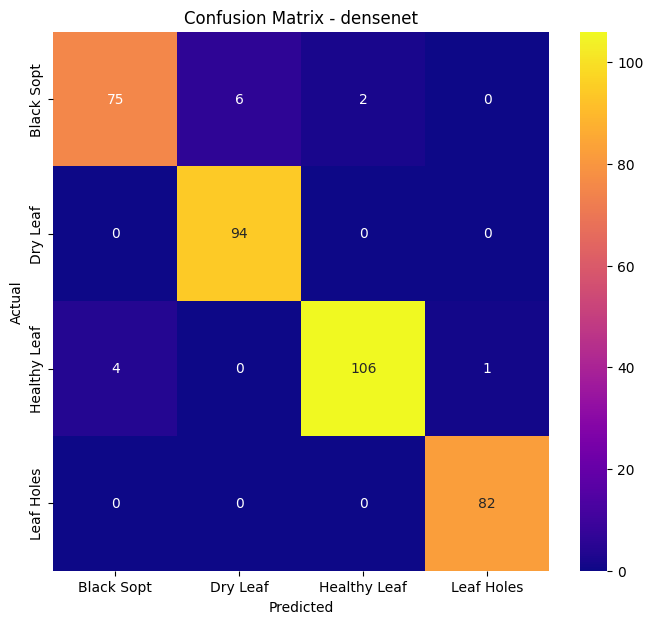

Saved final model to: /content/final_densenet.keras
RESULTS: {'model_key': 'densenet', 'val_loss': 0.05864742770791054, 'val_acc': 0.9729729890823364, 'sklearn_acc': 0.9648648648648649, 'final_path': '/content/final_densenet.keras', 'ckpt_path': '/content/best_densenet.keras'}


In [ ]:
# Cell 5: run one model (example: 'resnetv2')
results = train_and_evaluate('densenet')
print("RESULTS:", results)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet

# Paths (update if needed)
ROOT_DIR = '/content/drive/MyDrive/Dataset'   # dataset folder
SAVE_DIR = '/content'  # where your saved model is
FINAL_MODEL_PATH = os.path.join(SAVE_DIR, "final_densenet.keras")

# 1. Define model config just for DenseNet121
img_size = (224, 224)   # ✅ DenseNet uses 224x224

# 2. Generator (only validation split needed)
def get_val_generator(root_dir, img_size, preprocess_fn, batch_size=32, val_split=0.2, seed=42):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_fn, validation_split=val_split)
    val_gen = datagen.flow_from_directory(
        root_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', subset='validation', shuffle=False, seed=seed
    )
    return val_gen

val_gen = get_val_generator(ROOT_DIR, img_size, preprocess_densenet)  # ✅ FIXED

# 3. Load trained DenseNet model
assert os.path.exists(FINAL_MODEL_PATH), f"❌ Model not found: {FINAL_MODEL_PATH}"
model = load_model(FINAL_MODEL_PATH)

# 4. Evaluate and print accuracy
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"\n✅ Final Accuracy (DenseNet121): {val_acc*100:.2f}%")


Found 370 images belonging to 4 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 96s 7s/step - accuracy: 0.9618 - loss: 0.1130

✅ Final Accuracy (DenseNet121): 97.03%



MODEL: resnet input_size: (224, 224)
Found 1485 images belonging to 4 classes.
Found 370 images belonging to 4 classes.
Class names (index order): ['Black Sopt', 'Dry Leaf', 'Healthy Leaf', 'Leaf Holes']
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "ResNet50_custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/6
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5970 - loss: 1.3890 
Epoch 1: val_accuracy improved from -inf to 0.94865, saving model to /content/best_resnet.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 1034s 22s/step - accuracy: 0.5998 - loss: 1.3777 - val_accuracy: 0.9486 - val_loss: 0.1881 - learning_rate: 0.0010
Epoch 2/6
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8633 - loss: 0.3915 
Epoch 2: val_accuracy did not improve from 0.94865
47/47 ━━━━━━━━━━━━━━━━━━━━ 605s 13s/step - accuracy: 0.8634 - loss: 0.3910 - val_accuracy: 0.9405 - val_loss: 0.1843 - learning_rate: 0.0010
Epoch 3/6
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8766 - loss: 0.3429 
Epoch 3: val_accuracy improved from 0.94865 to 0.95405, saving model to /content/best_resnet.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 639s 14s/step - accuracy: 0.8768 - loss: 0.3427 - val_accuracy: 0.9541 - val_loss: 0.1675 - learning_rate: 0.0010
Epoch 4/6
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9179 - loss: 0.

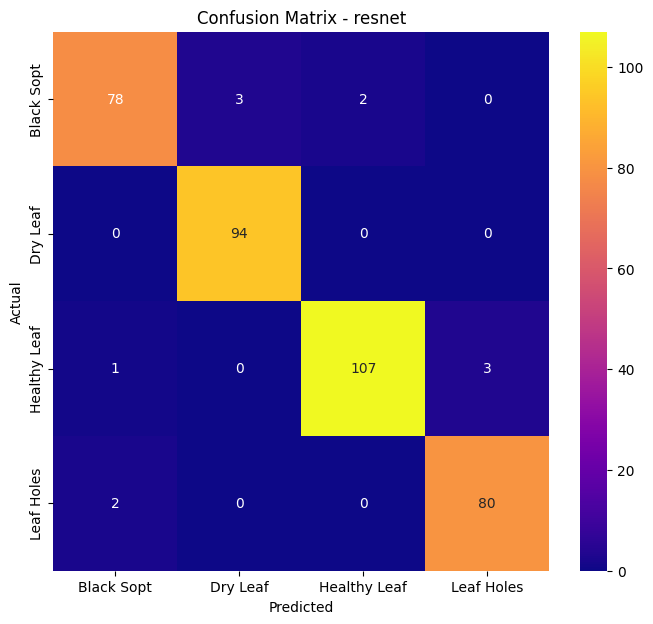

Saved final model to: /content/final_resnet.keras
RESULTS: {'model_key': 'resnet', 'val_loss': 0.06408301740884781, 'val_acc': 0.9783783555030823, 'sklearn_acc': 0.9702702702702702, 'final_path': '/content/final_resnet.keras', 'ckpt_path': '/content/best_resnet.keras'}


In [5]:
# Cell 5: run one model (example: 'resnetv2')
results = train_and_evaluate('resnet')
print("RESULTS:", results)


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet

# Paths (update if needed)
ROOT_DIR = '/content/drive/MyDrive/Dataset'   # dataset folder
SAVE_DIR = '/content'  # where your saved model is
FINAL_MODEL_PATH = os.path.join(SAVE_DIR, "final_resnet.keras")

# 1. Define model config just for DenseNet121
img_size = (224, 224)   # ✅ DenseNet uses 224x224

# 2. Generator (only validation split needed)
def get_val_generator(root_dir, img_size, preprocess_fn, batch_size=32, val_split=0.2, seed=42):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_fn, validation_split=val_split)
    val_gen = datagen.flow_from_directory(
        root_dir, target_size=img_size, batch_size=batch_size,
        class_mode='categorical', subset='validation', shuffle=False, seed=seed
    )
    return val_gen

val_gen = get_val_generator(ROOT_DIR, img_size, preprocess_densenet)  # ✅ FIXED

# 3. Load trained DenseNet model
assert os.path.exists(FINAL_MODEL_PATH), f"❌ Model not found: {FINAL_MODEL_PATH}"
model = load_model(FINAL_MODEL_PATH)

# 4. Evaluate and print accuracy
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"\n✅ Final Accuracy (ResNet50): {val_acc*100:.2f}%")


Found 370 images belonging to 4 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 118s 8s/step - accuracy: 0.0729 - loss: 9.5439

✅ Final Accuracy (ResNet50): 23.24%
